# `HF_classification . blanchefort . rubert-base-cased-sentiment-rusentiment . Extensive experiments . Saved model` notebook
### Descriprion
This notebook is one of those which were used to training large DL models from `transformers` library and measuring classification performance. Experiments with **rubert-base** model was conducted here. The model was profoundly explored via local resources and usage of Yandex.DataSphere platform. 

In [137]:
%ls

README.md
__pycache__/
bot.py
catboost_info/
data/
datasets_.py
models/
notebooks/
src/


In [135]:
%cd user-settings/

/home/jupyter/work/user-settings


In [138]:
from datasets_ import DatasetLoader

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd

import sys

from nltk import WhitespaceTokenizer

from transformers import (
    pipeline,                       
    AutoModelForSequenceClassification,                       
    BertForSequenceClassification,                       
    AutoTokenizer,
    AdamW,
)

In [151]:
#!g1.1
del_datasphere_variables('train')
del_datasphere_variables('test')

In [152]:
#!g1.1
train, test = DatasetLoader.load_reviews_Review_Label_dataset(train_test_split=True,
                                                              classnames_to_int=True,
                                                              remove_neutral_class=True,
                                                              show_path=True,)
train.label[train['label'] == 2] = 1
test.label[test['label'] == 2] = 1

print(train.label.value_counts())
train = pd.concat([train, resample(train[train.label == 0], n_samples=41608, random_state=42)])
print(train.label.value_counts())

print(train.shape, test.shape)

/home/jupyter/work/resources/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label.csv
label
1    48477
0     6869
Name: count, dtype: int64
label
0    48477
1    48477
Name: count, dtype: int64
(96954, 2) (23721, 2)


<ipython-input-4-8adfedff2195>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.label[train['label'] == 2] = 1
<ipython-input-4-8adfedff2195>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.label[test['label'] == 2] = 1


In [60]:
test

,review,label
25749,Большое количество фильмов советского кинемато...,1
44489,"Тяжело ответить на вопрос, что же такое Догвил...",1
53162,"В наше время такие героини, как скажем наприме...",0
25843,В 2001 году нам довелось познакомиться с новой...,1
44609,"«Это фильм?», «У них не хватило денег на декор...",1
...,...,...
14104,- Через столько лет?\r\n- Всегда\r\n\r\nБезусл...,1
22232,"После просмотра трейлера, я был под большим вп...",1
73314,"Многие не верят, но я легко подключаюсь к прои...",1
47848,"Как часто нам нужна поддержка? Да, пожалуй, оч...",1


In [147]:
# 

checkpoint = 'blanchefort/rubert-base-cased-sentiment-rusentiment'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [154]:
#!g1.1
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_model_input_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_model_input_length = max_model_input_length
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]
        review_tokenized = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_model_input_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids = review_tokenized['input_ids'].flatten()
        attn_mask = review_tokenized['attention_mask'].flatten()
        
        return {
            'review': review,
            'input_ids': input_ids,
            'attention_mask': attn_mask,
            'label': label,
        }
        

In [44]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [180]:
#!g1.1
class BertClassifier:
    def __init__(self, checkpoint, n_classes=2):
        
        self.model = AutoModelForSequenceClassification.from_pretrained(checkpoint, local_files_only=False, ignore_mismatched_sizes=True)
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = 768
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.5)
        
        self.all_losses = []
        self.epoch_losses = []
        self.epoch_acc = []       
        

    def fit(self):
        self.model.train()
        losses = []
        correct_predictions = 0
        
        t = tqdm(train_dataloader, file=sys.stdout, ncols=100)

        for data in t:
            input_ids = data['input_ids'].to(self.device)
            attention_mask = data['attention_mask'].to(self.device).to(float)
            labels = data['label'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = outputs.logits.argmax(dim=1)
            
            loss = self.loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)

            losses.append(loss.item())

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)


        train_acc = correct_predictions.double() / len(train_dataset)
        train_loss = np.mean(losses)
        self.all_losses.extend(losses)
        self.epoch_losses.append(train_loss)
        self.epoch_acc.append(train_acc)
        return train_acc, train_loss
    
    
    def evaluate(self):
        self.model.eval()
        losses = []
        correct_predictions = 0
        
        all_preds = []
        
        t = tqdm(test_dataloader, file=sys.stdout, ncols=100)

        with torch.no_grad():
            for data in t:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                labels = data["label"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, labels)
                correct_predictions += torch.sum(preds == labels)
                
                all_preds.extend(preds.tolist())
                
                losses.append(loss.item())
                
                t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)
                
        print('Classification report:')
        print(classification_report(test_dataset.labels, all_preds))

        val_acc = correct_predictions.double() / len(test_dataset)
        val_loss = np.mean(losses)
        return val_acc.item(), val_loss
    

    
    def train(self, n_epochs, pretrain_test=False):
        try:
            best_accuracy = 0

            if pretrain_test:
                print('Pre-training test:')
                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)

            for epoch in range(n_epochs):
                print(f'Epoch {epoch + 1}/{n_epochs}')
                train_acc, train_loss = self.fit()
                print(f'Train loss {train_loss} accuracy {train_acc}')

                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)
                
                # self.scheduler.step()
    
        except KeyboardInterrupt:
            print('Training was manually stopped. ')


In [156]:
#!g1.1
del_datasphere_variables('train_dataset')
del_datasphere_variables('test_dataset')
del_datasphere_variables('train_dataloader')
del_datasphere_variables('test_dataloader')

In [157]:
#!g1.1

clf = BertClassifier('blanchefort/rubert-base-cased-sentiment-rusentiment')

train_dataset = ReviewDataset(train.review, train.label, clf.tokenizer)
test_dataset = ReviewDataset(test.review, test.label, clf.tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [158]:
#!g1.1

for param in clf.model.bert.parameters():
    param.requires_grad = False
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 1538


#### batch_size=16, g1.1

In [159]:
#!g1.1

clf.model.device

device(type='cuda', index=0)

In [160]:
#!g1.1

clf.train(1, pretrain_test=True)

100%|██████████████████████████████████████████████| 6060/6060 [22:56<00:00,  4.40it/s, loss=0.0765]
Train loss 0.33121125836927356 accuracy 0.8558491655836789
100%|█████████████████████████████████████████████████| 1483/1483 [05:18<00:00,  4.66it/s, loss=0.4]
Classification report:
              precision    recall  f1-score   support

           0       0.56      0.85      0.67      2979
           1       0.98      0.90      0.94     20742

    accuracy                           0.90     23721
   macro avg       0.77      0.88      0.80     23721
weighted avg       0.92      0.90      0.90     23721

Test loss 0.24563305997820375 accuracy 0.8956620715821424
----------


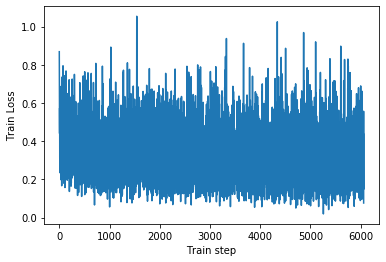

In [161]:
#!g1.1

plt.plot(clf.all_losses)
plt.xlabel('Train step')
plt.ylabel('Train Loss')

plt.show()

In [162]:
#!g1.1
clf.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)

In [163]:
#!g1.1

clf.optimizer = torch.optim.Adam(clf.model.parameters(), lr=5e-5)
clf.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)

In [164]:
#!g1.1

for param in clf.model.bert.parameters():
    param.requires_grad = True
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 177854978


In [165]:
#!g1.1

clf.train(1, pretrain_test=True)

100%|█████████████████████████████████████████████| 6060/6060 [56:30<00:00,  1.79it/s, loss=0.00078]
Train loss 0.12999410150657087 accuracy 0.9538750335210512
100%|███████████████████████████████████████████████| 1483/1483 [05:16<00:00,  4.69it/s, loss=0.031]
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2979
           1       0.98      0.97      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.88      0.90      0.89     23721
weighted avg       0.95      0.95      0.95     23721

Test loss 0.19570180533079928 accuracy 0.950507988701994
----------


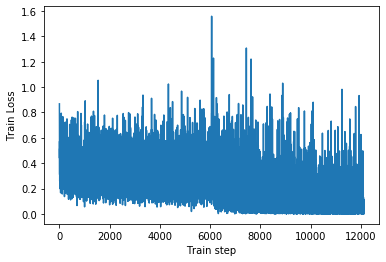

In [166]:
#!g1.1

plt.plot(clf.all_losses)
plt.xlabel('Train step')
plt.ylabel('Train Loss')

plt.show()

In [170]:
#!g1.1
clf.optimizer = torch.optim.Adam(clf.model.parameters(), lr=1e-5)
clf.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)

In [171]:
#!g1.1
clf.train(1, pretrain_test=False)

100%|█████████████████████████████████████████████| 6060/6060 [56:31<00:00,  1.79it/s, loss=0.00553]
Train loss 0.010916641023597157 accuracy 0.9972564308847495
100%|█████████████████████████████████████████████| 1483/1483 [05:15<00:00,  4.70it/s, loss=0.00306]
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      2979
           1       0.96      0.99      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.93      0.84      0.88     23721
weighted avg       0.95      0.95      0.95     23721

Test loss 0.3306930817049535 accuracy 0.95307954976603
----------


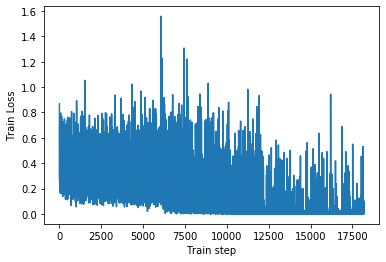

In [172]:
#!g1.1

plt.plot(clf.all_losses)
plt.xlabel('Train step')
plt.ylabel('Train Loss')

plt.show()

In [169]:
#!g1.1
import dill

with open('models/clf.model', 'wb') as f:
    dill.dump(clf, f)

In [175]:
#!g1.1
clf.tokenizer.save_pretrained('models/overfitted')
clf.model.save_pretrained('models/overfitted')

In [188]:
#!g1.1
clf.model.config

BertConfig {
  "_name_or_path": "models/overfitted",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.14.0",
  "type_

In [181]:
#!g1.1
clf1 = BertClassifier('models/overfitted')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/overfitted and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [194]:
#!g1.1
BertForSequenceClassification.from_pretrained('models/overfitted', config=clf.model.config, num_labels=2)

TypeError: __init__() got an unexpected keyword argument 'num_labels'

In [ ]:
#!g1.1
